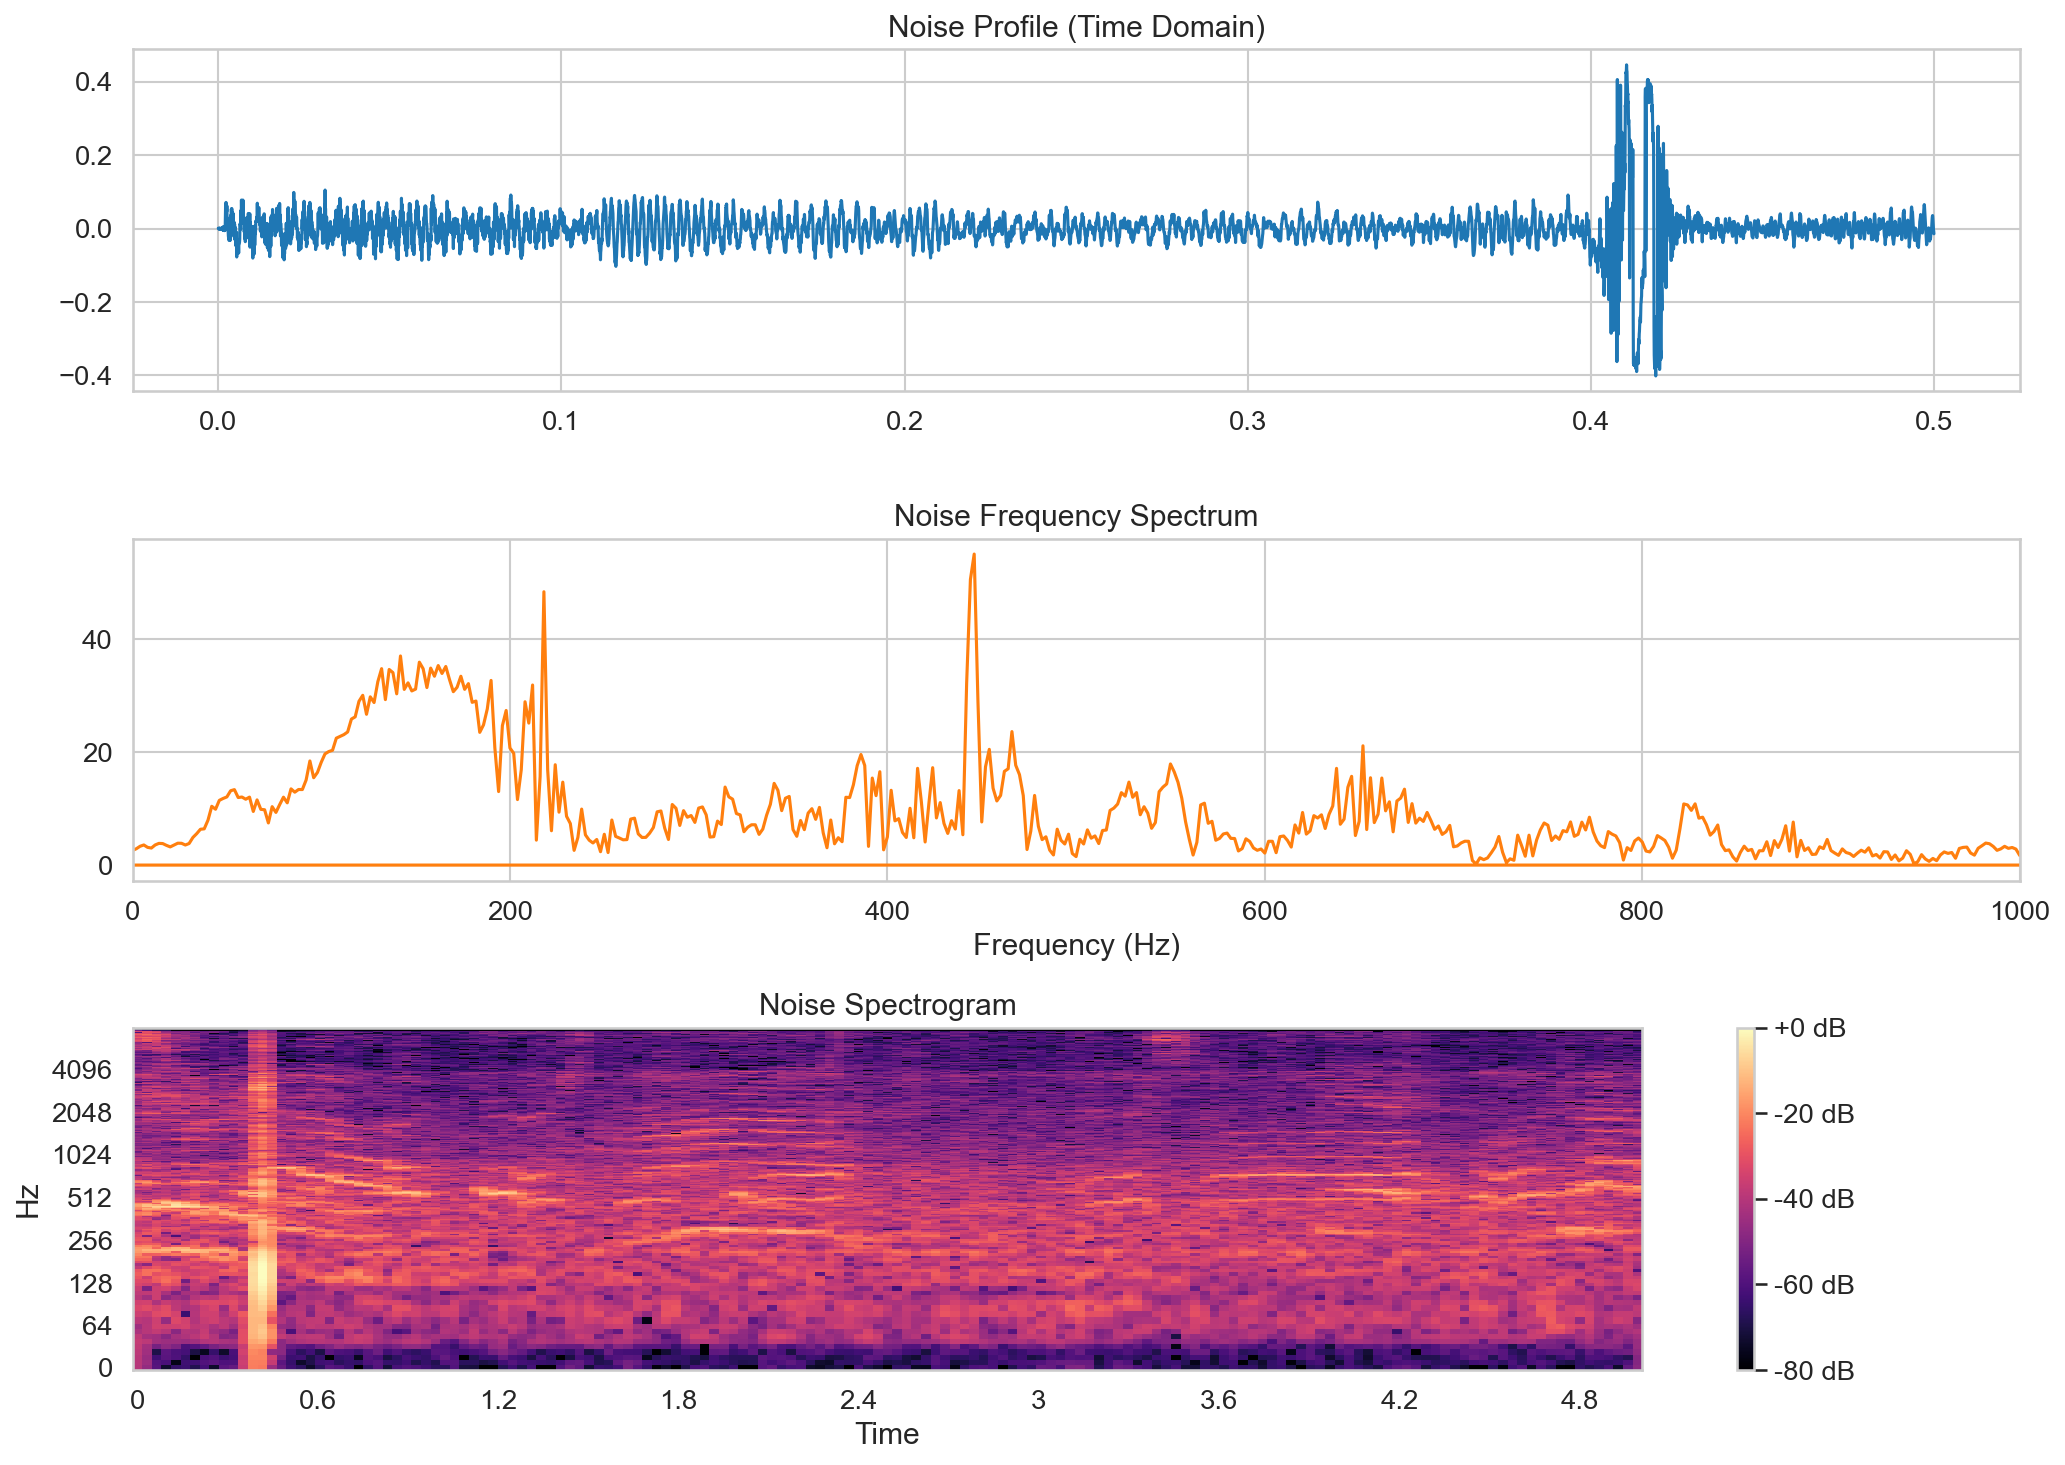

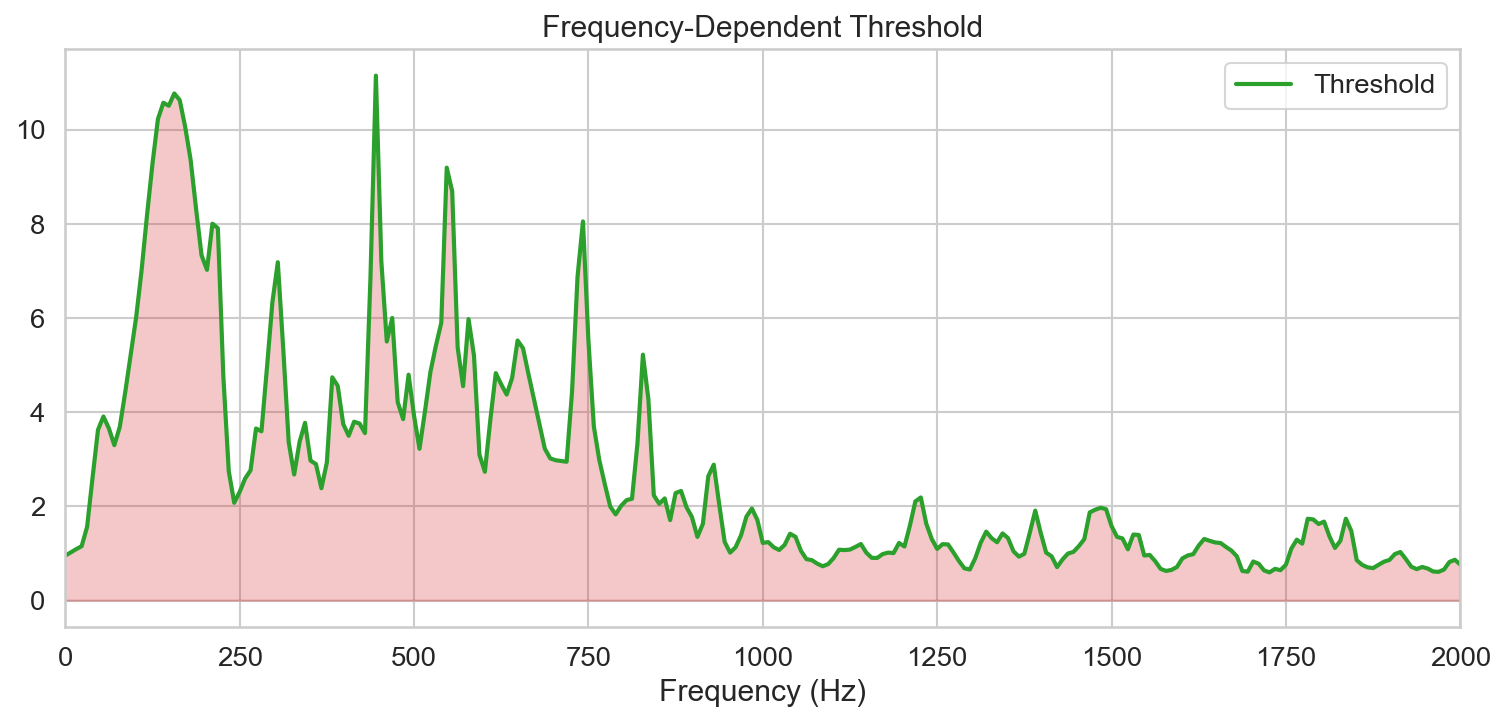

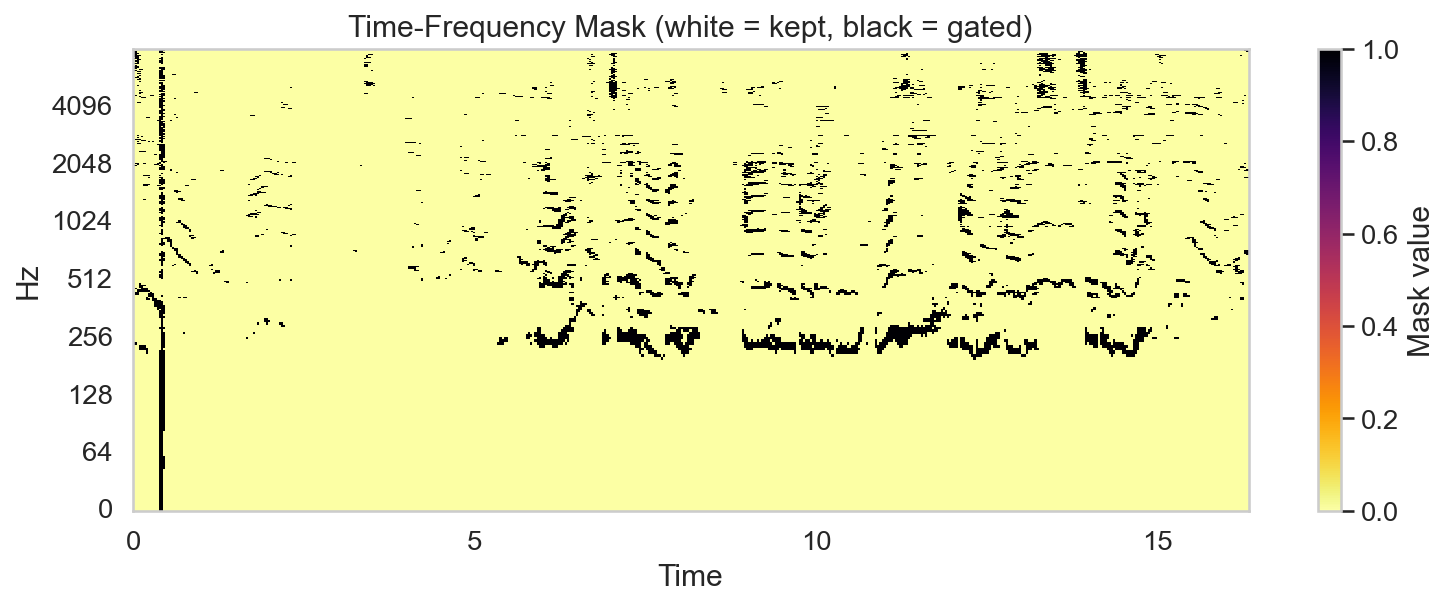

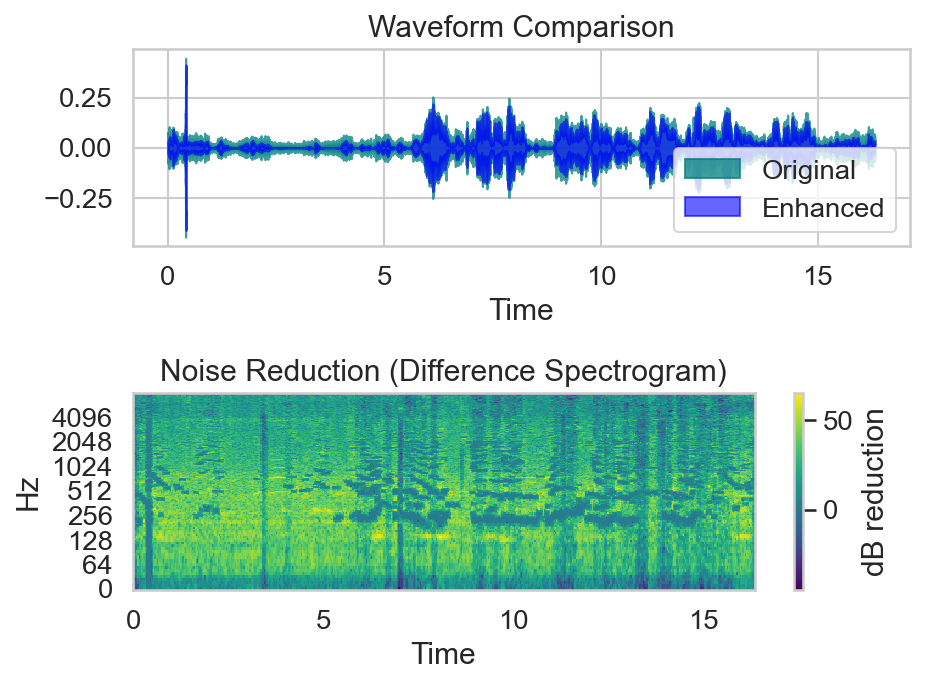

Original audio:


Enhanced audio:


In [61]:
import itertools
import librosa
import librosa.display
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Audio, display
from pathlib import Path
from scipy.signal import medfilt

# ── Where to save the PNGs ───────────────────────────────────────────────────
desktop = Path(r"C:\Users\AL-MALAK\Desktop")     # your Desktop folder

# ── Styling ──────────────────────────────────────────────────────────────────
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.dpi"] = 150
color_cycle = itertools.cycle(cm.tab10.colors)   # distinct colours

# ── Load audio ───────────────────────────────────────────────────────────────
file_path = r"C:\Desktop\CEP_1RECOrding.mp3"     # your MP3 location
y, sr = librosa.load(file_path, sr=16000)

noise_sample = y[: int(5 * sr)]                  # first 5 s for noise profile

# ── Spectral-gating denoiser ─────────────────────────────────────────────────
def spectral_gate(y, sr, noise_sample, n_std=3.0, n_fft=2048, hop=512):
    stft_noise  = librosa.stft(noise_sample, n_fft=n_fft, hop_length=hop)
    stft_signal = librosa.stft(y,           n_fft=n_fft, hop_length=hop)

    noise_mag = np.abs(stft_noise)
    threshold = np.mean(noise_mag, axis=1) + n_std * np.std(noise_mag, axis=1)

    mask = (np.abs(stft_signal) > threshold[:, None]).astype(float)
    y_clean = librosa.istft(stft_signal * mask, hop_length=hop)
    y_clean = medfilt(y_clean, kernel_size=3)
    return y_clean, mask, threshold

y_clean, mask, threshold = spectral_gate(y, sr, noise_sample)

# ── 1. Noise-profile analysis ────────────────────────────────────────────────
fig1 = plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(np.linspace(0, 0.5, int(0.5 * sr)),
         noise_sample[: int(0.5 * sr)],
         color=next(color_cycle))
plt.title("Noise Profile (Time Domain)")

plt.subplot(3, 1, 2)
noise_fft = np.abs(np.fft.fft(noise_sample[: int(0.5 * sr)]))[: sr // 2]
freqs     = np.fft.fftfreq(len(noise_sample[: int(0.5 * sr)]), 1 / sr)[: sr // 2]
plt.plot(freqs, noise_fft, color=next(color_cycle))
plt.title("Noise Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.xlim(0, 1000)

plt.subplot(3, 1, 3)
D_noise = librosa.amplitude_to_db(np.abs(librosa.stft(noise_sample)), ref=np.max)
librosa.display.specshow(D_noise, sr=sr, x_axis="time", y_axis="log", cmap="magma")
plt.title("Noise Spectrogram")
plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
fig1.savefig(desktop / "noise_analysis.png", bbox_inches="tight")
plt.show()

# ── 2. Threshold curve ───────────────────────────────────────────────────────
fig2 = plt.figure(figsize=(12, 5))
c = next(color_cycle)
freq_bins = librosa.fft_frequencies(sr=sr, n_fft=2048)
plt.plot(freq_bins, threshold, color=c, lw=2, label="Threshold")
plt.fill_between(freq_bins, 0, threshold, alpha=0.25, color=next(color_cycle))
plt.title("Frequency-Dependent Threshold")
plt.xlabel("Frequency (Hz)")
plt.xlim(0, 2000)
plt.grid(True)
plt.legend()
fig2.savefig(desktop / "threshold_plot.png", bbox_inches="tight")
plt.show()

# 3. Binary mask  ─────────────────────────────────────────
fig3 = plt.figure(figsize=(12, 4))
librosa.display.specshow(mask, sr=sr,
                         x_axis="time", y_axis="log",
                         cmap="inferno_r")          # ← new cmap
plt.title("Time-Frequency Mask (white = kept, black = gated)")
plt.colorbar(label="Mask value")
fig3.savefig(desktop / "time_frequency_mask.png", bbox_inches="tight")
plt.show()

# 4a. Waveforms  ──────────────────────────────────────────
plt.subplot(2, 1, 1)
librosa.display.waveshow(y,       sr=sr,
                          color="#008080",   # teal
                          alpha=0.75, label="Original")
librosa.display.waveshow(y_clean, sr=sr,
                          color="#0000FF",   # blue
                          alpha=0.6,  label="Enhanced")
plt.title("Waveform Comparison")
plt.legend()

# 4b. Difference spectrogram  ────────────────────────────
plt.subplot(2, 1, 2)
librosa.display.specshow(D_orig - D_clean, sr=sr,
                         x_axis="time", y_axis="log",
                         cmap="viridis")            # ← smoother sequential cmap
plt.title("Noise Reduction (Difference Spectrogram)")
plt.colorbar(label="dB reduction")


plt.tight_layout()
fig4.savefig(desktop / "enhancement_results.png", bbox_inches="tight")
plt.show()

# ── Listen ───────────────────────────────────────────────────────────────────
print("Original audio:")
display(Audio(y, rate=sr))
print("Enhanced audio:")
display(Audio(y_clean, rate=sr))
